In [1]:
import networkx as nx
import pickle
from multiprocessing import Pool

import numpy as np; np.set_printoptions(suppress=True, linewidth=180); np.seterr(divide='ignore')
import pandas as pd; pd.set_option('display.width', 500)
import matplotlib.pyplot as plt

from plot_module import plot_ode_results, plot_sde_results, plot_simulator_graph, plot_neuron_graph_subset, plot_twocomponent_results, plot_onecomponent_results
from sim_param_from_network import names_from_network, sde_param_from_network, ode_from_network, start_state_from_nodes
from neuron_graph_process import neuron_graph_process
from neuron_graph_helper import load_pickled_neuron_graph
from analyse_simulation import two_component_statistics, one_component_statistics

from simulate import simulate_ode, simulate_gillespie, simulate_tauleaping

## Simulate with 0 control to get data about brownian process

In [19]:
model = 'model_1node'
G = load_pickled_neuron_graph(f'neuron_graphs/{model}.pkl')

DELTA = 0.25
NSS = 210
for node, data in G.nodes(data = True):
    if data['nodetype'] == 1:
        data['delta'] = DELTA
    data['nss'] = NSS

VARS, NODES = names_from_network(G)
START_STATE = start_state_from_nodes(G, heteroplasmy=0.0, delta=DELTA)
print(START_STATE)
print(START_STATE[0]+DELTA*START_STATE[1])

T = 30000
TIME_POINTS = np.linspace(0, T, 101)
REP = 100000

c_b = 0.0

print(f"\n<<<< STARTING SIMULATION WITH C_B = {c_b} >>>>\n")

for node, data in G.nodes(data = True):
    if data['nodetype'] == 1:
        data['c_b'] = c_b

# infer the parameterse of the sde systems
SDE_PARAM = sde_param_from_network(G, prnt=False)

# run the gillespie simulation
gillespie_results = simulate_gillespie(SDE_PARAM, TIME_POINTS, START_STATE, replicates=REP)
df_g = one_component_statistics(gillespie_results, TIME_POINTS, DELTA)

print(df_g.iloc[[0, -1]]);print()
plot_onecomponent_results(df_g)

[210, 0]
210.0

<<<< STARTING SIMULATION WITH C_B = 0.0 >>>>

simulating using gillespie...


100%|██████████| 100000/100000 [2:15:31<00:00, 12.30it/s]  


FileNotFoundError: [Errno 2] No such file or directory: 'sim_out/model_1node/c0_tauleaping_results.pkl'

## Estimate D parameter from observed changes in variance

175.72218669221965


87.8611

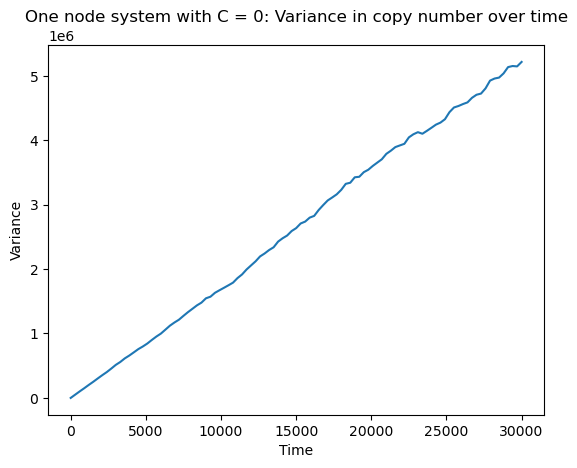

In [23]:
variances = np.nanvar(gillespie_results[:,0,:], axis = 0)

plt.plot(TIME_POINTS, variances)
plt.xlabel('Time')
plt.ylabel('Variance')
plt.title('One node system with C = 0: Variance in copy number over time')
slope = np.dot(TIME_POINTS, variances) / np.dot(TIME_POINTS, TIME_POINTS)
print(slope)
D_estimated = np.round(slope / 2, 4)
D_estimated = 88.0

In [4]:
def integral_from_point(f, x, point_x):
    positive_integral = [np.trapz(f[point_x:i], pop_val[point_x:i]) for i in range(point_x, len(x))]
    negative_integral = np.array([np.trapz(-f[(point_x-i):point_x][::-1], x[(point_x-i):point_x][::-1]) for i in range(0, point_x)])[::-1]
    integral = list(negative_integral)
    integral.extend(positive_integral)
    return np.array(integral)

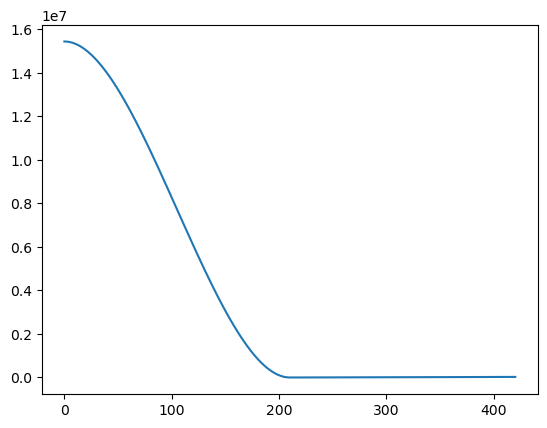

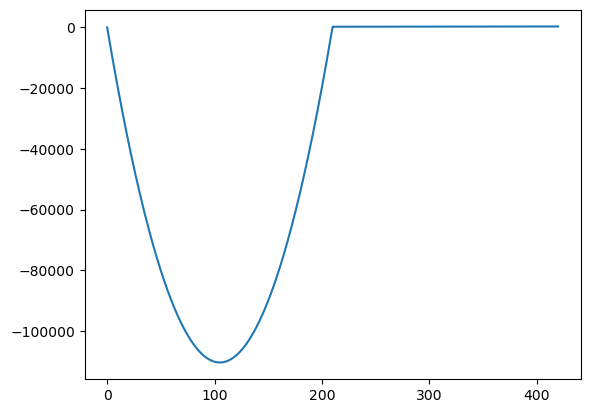

In [5]:
NSS = 210
Birth = 0.4
Death = 0.4
c = 10

def return_strength(pop, c):
    return (pop*(max(0, Birth+(c*(NSS-pop)))-Death))

pop_val = np.linspace(0, 420, 10001)
center_i = np.where(pop_val == NSS)[0][0]
abs_net_change = np.array([abs(return_strength(pop, c)) for pop in pop_val])
integral = integral_from_point(abs_net_change, pop_val, center_i)
plt.plot(pop_val, integral)
plt.show()
gradient = np.gradient(integral, pop_val)

plt.plot(pop_val, gradient)

In [6]:
c = 0.00001
def potential_gradient(x, c):
    # Replace this with the gradient of your potential energy function
    return -(x*(max(0, Birth+(c*(NSS-x)))-Death))

def simulate_OU(alpha, D, x0, dt, T, c):
    n = int(T / dt)
    x = np.zeros(n)
    
    # precompute the brownian motion component
    brownian_arr = np.sqrt(2*D) * np.sqrt(dt) * np.random.randn(n)
    
    x[0] = x0
    for i in range(1, n):
        #dW = np.sqrt(dt) * randn_arr[i]
        x[i] = x[i-1] - (alpha*potential_gradient(x[i-1], c)*dt) + (brownian_arr[i])
        if x[i] <= 0:
            break
            
    x = np.array(x)[::10]
    return x

def wrapper(args):
    return simulate_OU(*args)

def parallel_simulation(rep, alpha, D, x0, dt, T, c):
    with Pool(10) as pool:
        # Package arguments for each simulation into a list of tuples
        args = [(alpha, D, x0, dt, T, c_b) for _ in range(rep)]
        # Execute simulations in parallel
        results = pool.map(wrapper, args)

    return np.array(results)

preparing to simulate model_1node with the following parameters:
[0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10, 1e-11] 


<<<< STARTING SIMULATION WITH C_B = 1e-05 >>>>



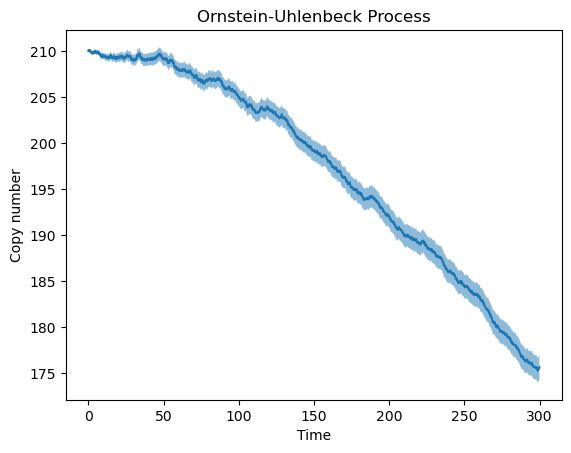

175.94
0.67


In [18]:
C_B_val = sequence = [round(i * 10**-decimals, 14) for decimals in range(2, 13) for i in range(10, 0, -1)]
C_B_val = [element for i, element in enumerate(C_B_val) if i % 10 == 0] # sparseify for testing
print(f"preparing to simulate {model} with the following parameters:")
print(C_B_val, '\n')

C_B_val = [0.00001]

for c_b in C_B_val:
    print(f"\n<<<< STARTING SIMULATION WITH C_B = {c_b} >>>>\n")
    
    # Parameters
    alpha = 1
    D = 75.0

    x0 = NSS
    T = 300.0
    dt = 0.01

    rep = 50000
    x_res = parallel_simulation(rep, alpha, D, x0, dt, T, c_b)
    
    x = np.mean(x_res, axis = 0)
    x_sem = np.nanstd(x_res, axis = 0)/np.sqrt(rep)
    
    t = np.arange(0, T, dt*10)

    plt.plot(t, x)
    plt.fill_between(t, x-(2*x_sem), x+(2*x_sem), alpha = 0.5)
    plt.xlabel('Time')
    plt.ylabel('Copy number')
    plt.title('Ornstein-Uhlenbeck Process')
    plt.show()

    print(np.round(np.mean(x[-100:-1]    ), 2))
    print(np.round(x_sem[-1], 2))

In [ ]:
print(np.round(np.mean(x[-1000:-1]    ), 2))
print(np.round(x_sem[-1], 2))

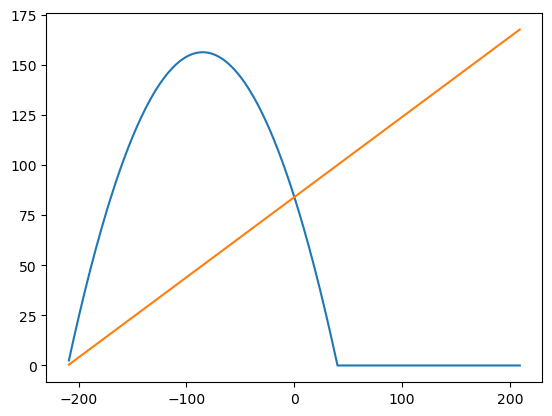

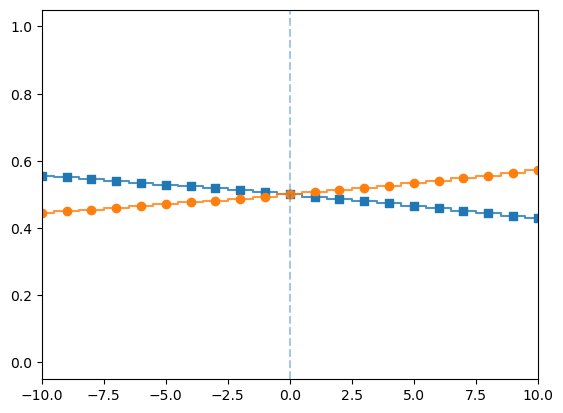

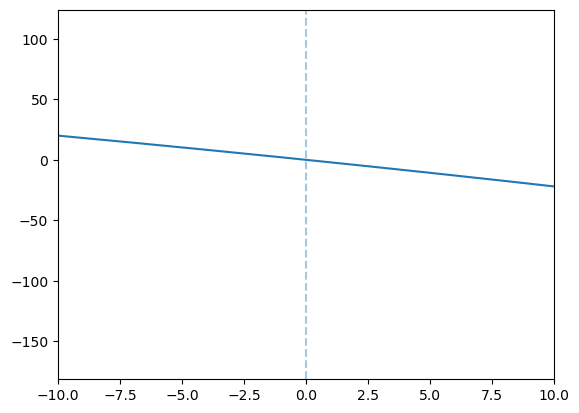

In [9]:
c = 0.01
x = 210; y = 15

def p_b_d(y):
    p_b = max(0, Birth+(c*(NSS-(NSS+y))))*(x+y)
    p_d = Death*(x+y)
    return p_b, p_d

# r_p_b = p_b/(p_b+p_d)
# r_p_d = p_d/(p_b+p_d)
# #print(p_b, p_d)
# print(r_p_b, r_p_d)
# print(r_p_b/r_p_d)

pop_diff = np.arange(-209, 210, 1)

r_p_b = np.array([p_b_d(diff)[0] for diff in pop_diff])
r_p_d = np.array([p_b_d(diff)[1] for diff in pop_diff])
plt.plot(pop_diff, r_p_b)
plt.plot(pop_diff, r_p_d)
plt.show()


r_p_b_r = np.array([p_b_d(diff)[0]/(p_b_d(diff)[0]+p_b_d(diff)[1]) for diff in pop_diff])
r_p_d_r = np.array([p_b_d(diff)[1]/(p_b_d(diff)[0]+p_b_d(diff)[1]) for diff in pop_diff])
plt.step(pop_diff, r_p_b_r, where='mid',alpha = 0.8)
plt.scatter(pop_diff, r_p_b_r, marker = 's' )
plt.step(pop_diff, r_p_d_r, where='mid',alpha = 0.8)
plt.scatter(pop_diff, r_p_d_r)
plt.axvline(0, alpha = 0.4, linestyle='dashed')
plt.xlim([-10, 10])
plt.show()
# sampling_rate = (r_p_b+r_p_d)/sum(list(p_b_d(0)))
# plt.plot(pop_diff, sampling_rate)
# plt.show()

plt.plot(pop_diff, r_p_b-r_p_d)
plt.axvline(0, alpha = 0.4, linestyle='dashed')
plt.xlim([-10, 10])
plt.show()

# plt.plot(integral_from_point(r_p_b, pop_diff, NSS))
# plt.plot(integral_from_point(r_p_d, pop_diff, NSS))